# Aurora Forecasting - Part 03: Training Pipeline

🗒️ This notebook is divided into the following sections:
Initialize Hopsworks connection and retrieve Feature Groups.

Create a Feature View and Training Dataset.

Train a Random Forest model to predict the Kp index from solar wind features.

Evaluate model performance.

Register the model in the Hopsworks Model Registry.

# Import and setup


In [1]:
import pandas as pd
import hopsworks
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import joblib
import os
import util
from config import HopsworksSettings

# Setup settings
settings = HopsworksSettings()

# Login to Hopsworks
project = hopsworks.login(
    project=settings.HOPSWORKS_PROJECT,
    api_key_value=settings.HOPSWORKS_API_KEY.get_secret_value()
)
fs = project.get_feature_store()

2026-01-11 03:09:50,704 WARNING: UserWarning: Qin-Denton/OMNI2 data not found in current format. This module has limited functionality. Run spacepy.toolbox.update(QDomni=True) to download data.

HopsworksSettings initialized!
2026-01-11 03:09:50,793 INFO: Initializing external client
2026-01-11 03:09:50,794 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-11 03:09:51,479 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2026-01-11 03:09:52,418 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1299605


# Create the lagged features

In [2]:
# Get the solar wind feature group
solar_wind_aggregated_fg = fs.get_feature_group(name="solar_wind_aggregated_fg", version=3)
merged_df = solar_wind_aggregated_fg.read()
merged_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.09s) 


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_std,speed_mean,speed_min,speed_max,speed_std,dynamic_pressure_mean,dynamic_pressure_min,dynamic_pressure_max,dynamic_pressure_std,kp_index
0,2025-02-24 00:00:00+00:00,2025-02-24 03:00:00+00:00,8.400001,7.6,8.9,0.700000,5.433333,2.4,8.0,2.829016,...,2.402776,339.666656,338.0,342.0,2.081666,2.184894e+06,1.896450e+06,2.459309e+06,2.816915e+05,3.0
1,2022-12-15 06:00:00+00:00,2022-12-15 09:00:00+00:00,-2.900000,-4.5,-1.2,1.652271,-3.600000,-6.1,-0.3,2.981610,...,0.173205,342.000000,337.0,348.0,5.567764,8.890131e+05,8.517675e+05,9.082800e+05,3.226207e+04,1.7
2,2025-01-01 15:00:00+00:00,2025-01-01 18:00:00+00:00,0.366666,-8.8,6.7,8.129166,-16.433332,-21.5,-7.3,7.925486,...,13.266123,497.666656,482.0,519.0,19.139835,4.479906e+06,2.114148e+06,8.808105e+06,3.753751e+06,8.0
3,2023-08-02 03:00:00+00:00,2023-08-02 06:00:00+00:00,-9.033334,-10.5,-7.5,1.501111,4.100000,0.7,6.2,2.971532,...,2.761038,397.666656,395.0,400.0,2.516612,1.590366e+06,1.092175e+06,1.984000e+06,4.550132e+05,1.3
4,2021-03-20 00:00:00+00:00,2021-03-20 03:00:00+00:00,-8.066667,-11.3,-5.2,3.066486,4.700000,-2.0,10.3,6.223343,...,8.105143,343.666656,331.0,351.0,11.015141,4.658192e+06,3.880832e+06,5.809908e+06,1.017566e+06,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28655,2019-09-07 03:00:00+00:00,2019-09-07 06:00:00+00:00,1.900000,0.9,2.6,0.888819,-0.366667,-0.7,-0.2,0.288675,...,0.513160,472.000000,469.0,475.0,3.000000,5.418374e+05,4.512500e+05,6.683520e+05,1.129220e+05,1.3
28656,2019-08-06 03:00:00+00:00,2019-08-06 06:00:00+00:00,0.433333,-0.7,1.2,1.001665,1.500000,1.2,1.8,0.300000,...,0.100000,713.000000,712.0,715.0,1.732051,1.016885e+06,9.631936e+05,1.073572e+06,5.525045e+04,2.7
28657,2016-10-12 06:00:00+00:00,2016-10-12 09:00:00+00:00,-2.366667,-3.4,-1.7,0.907377,0.833333,0.1,1.9,0.945163,...,0.152752,374.333344,367.0,380.0,6.658328,7.754642e+05,7.407895e+05,8.058432e+05,3.273890e+04,0.7
28658,2016-08-16 06:00:00+00:00,2016-08-16 09:00:00+00:00,3.566667,2.9,4.0,0.585946,-0.733333,-1.0,-0.6,0.230940,...,0.435890,296.333344,291.0,302.0,5.507571,5.974321e+05,5.519808e+05,6.475484e+05,4.795427e+04,0.7


In [3]:
# Create lagged features for solar wind data to capture temporal dependencies
# Sort by chronological order
merged_df = merged_df.sort_values('window_start').reset_index(drop=True)

# 3h, 6h of lagging of the features (with time-consecutive validation)
merged_df = util.lag_features(
    df=merged_df,
    feature_cols=["bz_gsm_mean", "bz_gsm_min", "speed_mean", "density_mean", "dynamic_pressure_mean", "dynamic_pressure_max", "dynamic_pressure_std"],
    lags=[1, 2],
    time_col="window_start",
    time_end_col="window_end",
    check_consecutive=True  # Only assign lags when time windows are consecutive
)

# Drop rows with NaNs introduced by lagging (gaps or end of series)
print(f"Rows before dropping NaNs: {len(merged_df)}")
merged_df = merged_df.dropna().reset_index(drop=True)
print(f"Rows after dropping NaNs: {len(merged_df)}")
merged_df

Rows before dropping NaNs: 28660
Rows after dropping NaNs: 28497


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,speed_mean_lag_1,speed_mean_lag_2,density_mean_lag_1,density_mean_lag_2,dynamic_pressure_mean_lag_1,dynamic_pressure_mean_lag_2,dynamic_pressure_max_lag_1,dynamic_pressure_max_lag_2,dynamic_pressure_std_lag_1,dynamic_pressure_std_lag_2
0,2016-01-14 06:00:00+00:00,2016-01-14 09:00:00+00:00,-3.066667,-4.00,-1.90,1.069268,-1.433333,-3.10,1.00,2.154840,...,509.666656,521.000000,2.600000,2.700000,6.782998e+05,7.332174e+05,7.717500e+05,7.641648e+05,98038.945312,43766.242188
1,2016-01-14 09:00:00+00:00,2016-01-14 12:00:00+00:00,-0.900000,-3.20,1.30,2.251666,0.700000,-1.10,2.20,1.670329,...,514.000000,509.666656,2.666667,2.600000,7.045628e+05,6.782998e+05,7.441850e+05,7.717500e+05,47021.332031,98038.945312
2,2016-01-14 12:00:00+00:00,2016-01-14 15:00:00+00:00,-1.500000,-2.40,-0.70,0.854400,-0.500000,-1.90,0.90,1.400000,...,502.333344,514.000000,2.800000,2.666667,7.062038e+05,7.045628e+05,7.197372e+05,7.441850e+05,12906.429688,47021.332031
3,2016-01-14 15:00:00+00:00,2016-01-14 18:00:00+00:00,-2.200000,-2.50,-1.70,0.435890,-2.566667,-2.90,-1.90,0.577350,...,468.000000,502.333344,2.566667,2.800000,5.645089e+05,7.062038e+05,6.451200e+05,7.197372e+05,85949.335938,12906.429688
4,2016-01-14 18:00:00+00:00,2016-01-14 21:00:00+00:00,-2.700000,-3.20,-2.00,0.624500,0.133333,-2.00,2.50,2.259056,...,479.666656,468.000000,2.733333,2.566667,6.279268e+05,5.645089e+05,6.797280e+05,6.451200e+05,45208.832031,85949.335938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28492,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,...,479.466675,479.899994,4.663333,5.710000,1.076010e+06,1.315656e+06,1.284438e+06,1.723240e+06,180520.421875,392114.281250
28493,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,...,485.133331,479.466675,4.040000,4.663333,9.540338e+05,1.076010e+06,1.238526e+06,1.284438e+06,371794.281250,180520.421875
28494,2026-01-10 12:00:00+00:00,2026-01-10 15:00:00+00:00,1.796667,-2.61,5.16,3.988688,-5.576667,-6.94,-3.96,1.506065,...,483.799988,485.133331,3.903333,4.040000,9.257776e+05,9.540338e+05,1.234700e+06,1.238526e+06,278013.562500,371794.281250
28495,2026-01-10 15:00:00+00:00,2026-01-10 18:00:00+00:00,-3.656667,-7.20,-1.85,3.068816,-5.313334,-6.44,-3.50,1.585728,...,482.466675,483.799988,5.283333,3.903333,1.230068e+06,9.257776e+05,1.452034e+06,1.234700e+06,352920.843750,278013.562500


In [4]:
# Create Kp index lagged for +3h and +6h prediction
# Target DIRECT forecasting (forward=True for future values)

merged_df = util.lag_features(
    df=merged_df,
    feature_cols=["kp_index"],
    lags=[1, 2],  # +3h (1 window) and +6h (2 windows)
    time_col="window_start",
    time_end_col="window_end",
    check_consecutive=True,
    forward=True  # Creates kp_index_t_plus_1, kp_index_t_plus_2
)

# Drop rows with NaNs introduced by lagging (gaps or end of series)
print(f"Rows before dropping NaNs: {len(merged_df)}")
merged_df = merged_df.dropna().reset_index(drop=True)
print(f"Rows after dropping NaNs: {len(merged_df)}")

merged_df

Rows before dropping NaNs: 28497
Rows after dropping NaNs: 28342


,window_start,window_end,by_gsm_mean,by_gsm_min,by_gsm_max,by_gsm_std,bz_gsm_mean,bz_gsm_min,bz_gsm_max,bz_gsm_std,...,density_mean_lag_1,density_mean_lag_2,dynamic_pressure_mean_lag_1,dynamic_pressure_mean_lag_2,dynamic_pressure_max_lag_1,dynamic_pressure_max_lag_2,dynamic_pressure_std_lag_1,dynamic_pressure_std_lag_2,kp_index_plus_1,kp_index_plus_2
0,2016-01-14 06:00:00+00:00,2016-01-14 09:00:00+00:00,-3.066667,-4.00,-1.90,1.069268,-1.433333,-3.10,1.00,2.154840,...,2.600000,2.700000,6.782998e+05,7.332174e+05,7.717500e+05,7.641648e+05,98038.945312,43766.242188,2.00,1.70
1,2016-01-14 09:00:00+00:00,2016-01-14 12:00:00+00:00,-0.900000,-3.20,1.30,2.251666,0.700000,-1.10,2.20,1.670329,...,2.666667,2.600000,7.045628e+05,6.782998e+05,7.441850e+05,7.717500e+05,47021.332031,98038.945312,1.70,1.70
2,2016-01-14 12:00:00+00:00,2016-01-14 15:00:00+00:00,-1.500000,-2.40,-0.70,0.854400,-0.500000,-1.90,0.90,1.400000,...,2.800000,2.666667,7.062038e+05,7.045628e+05,7.197372e+05,7.441850e+05,12906.429688,47021.332031,1.70,1.70
3,2016-01-14 15:00:00+00:00,2016-01-14 18:00:00+00:00,-2.200000,-2.50,-1.70,0.435890,-2.566667,-2.90,-1.90,0.577350,...,2.566667,2.800000,5.645089e+05,7.062038e+05,6.451200e+05,7.197372e+05,85949.335938,12906.429688,1.70,2.70
4,2016-01-14 18:00:00+00:00,2016-01-14 21:00:00+00:00,-2.700000,-3.20,-2.00,0.624500,0.133333,-2.00,2.50,2.259056,...,2.733333,2.566667,6.279268e+05,5.645089e+05,6.797280e+05,6.451200e+05,45208.832031,85949.335938,2.70,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28337,2025-12-09 15:00:00+00:00,2025-12-09 18:00:00+00:00,2.000000,1.20,3.30,1.135782,-3.500000,-4.00,-2.90,0.556776,...,1.400000,1.366667,1.666350e+05,2.077580e+05,1.785375e+05,2.364135e+05,16832.677734,28265.578125,1.30,1.30
28338,2025-12-09 18:00:00+00:00,2025-12-09 21:00:00+00:00,-1.700000,-3.20,-0.40,1.410674,-2.133333,-2.60,-1.80,0.416333,...,3.166667,1.400000,4.226806e+05,1.666350e+05,4.679794e+05,1.785375e+05,39250.859375,16832.677734,1.30,2.00
28339,2026-01-10 06:00:00+00:00,2026-01-10 09:00:00+00:00,-1.316667,-5.06,2.24,3.653578,-4.330000,-6.25,-1.08,2.830000,...,4.663333,5.710000,1.076010e+06,1.315656e+06,1.284438e+06,1.723240e+06,180520.421875,392114.281250,2.67,4.33
28340,2026-01-10 09:00:00+00:00,2026-01-10 12:00:00+00:00,-3.463333,-6.79,1.88,4.673589,-4.856667,-8.41,-2.40,3.151513,...,4.040000,4.663333,9.540338e+05,1.076010e+06,1.238526e+06,1.284438e+06,371794.281250,180520.421875,4.33,3.33


In [5]:
# # Create lagged for the KP index to capture temporal dependencies
# merged_df = solar_wind_fg.read()
# # Ensure the date column is in datetime format
# merged_df['date_and_time'] = pd.to_datetime(merged_df['date_and_time'], errors='coerce')
# # Sort by chronological order
# merged_df = merged_df.sort_values('date_and_time').reset_index(drop=True)

# LAGS = [1, 2, 3, 4]  # 30m, 60m, 90m, 120m

# for col in ['by_gsm', 'bz_gsm', 'density', 'speed']:
#     for lag in LAGS:
#         merged_df[f"{col}_lag_{lag}"] = merged_df[col].shift(lag)

# # Drop rows with NaN values created by lagging
# merged_df = merged_df.dropna().reset_index(drop=True)

# merged_df

In [6]:
# # Add rolling statistics features
# WINDOWS = [2, 4]  # 1h, 2h

# for col in ['bz_gsm', 'speed', 'density']:
#     for w in WINDOWS:
#         merged_df[f"{col}_roll_mean_{w}"] = merged_df[col].rolling(w).mean()
#         merged_df[f"{col}_roll_std_{w}"] = merged_df[col].rolling(w).std()

# # Drop rows with NaN values created by rolling statistics
# merged_df = merged_df.dropna().reset_index(drop=True)
# merged_df

In [7]:
# # Dynamic pressure 
# # Pdyn ~ n * v^2 (unità non critiche per RF)
# merged_df['dynamic_pressure'] = merged_df['density_mean'] * (merged_df['speed_mean'] ** 2)

# merged_df

In [8]:
# Drop the non-lagged features, because they are non relevant for the prediction
#merged_df = merged_df.drop(columns=['by_gsm', 'bz_gsm', 'density', 'speed'])

In [9]:
# # Recreate train-test split after feature engineering
# split_index = int(0.8 * len(merged_df))
# train_df = merged_df.iloc[:split_index]
# test_df = merged_df.iloc[split_index:]

# # Drop kp_index from train and test. Add it to y_train and y_test
# y_train = train_df['kp_index']
# y_test = test_df['kp_index']
# X_train = train_df.drop(columns=['date_and_time', 'kp_index'])
# X_test = test_df.drop(columns=['date_and_time', 'kp_index'])

# X_train

# Create the new feature group

In [10]:
aurora_fg = fs.get_or_create_feature_group(
    name="aurora_solarwind_features",
    version=9,
    description="Solar wind features with lag and rolling statistics for Kp prediction",
    primary_key=["window_start", "window_end"],
    event_time="window_start",
)

aurora_fg.insert(merged_df)

print("Aurora feature group inserted successfully.")


Uploading Dataframe: 100.00% |██████████| Rows 28342/28342 | Elapsed Time: 00:03 | Remaining Time: 00:00


Launching job: aurora_solarwind_features_9_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1299605/jobs/named/aurora_solarwind_features_9_offline_fg_materialization/executions
Aurora feature group inserted successfully.


# Create feature view


In [11]:
# # Remove date_and_time and kp_index before creating the feature view 
# feature_columns = [
#     col for col in merged_df.columns
#     if col not in ['kp_index', 'date_and_time']
# ]

In [12]:
# Get the solar wind feature group
aurora_fg = fs.get_feature_group(name="aurora_solarwind_features", version=9)

# Select features and the label
query = aurora_fg.select_all()

# Create or retrieve the Feature View
# Note: Weather data is used for visibility logic in inference,
# while Kp is predicted solely from solar wind data.
aurora_fv = fs.get_or_create_feature_view(
    name="aurora_kp_view",
    version=10,
    description="Predicting the Kp index from solar wind parameters",
    labels=["kp_index_plus_1", "kp_index_plus_2"],
    query=query
)

print("Feature View created/retrieved successfully.")

Feature View created/retrieved successfully.


# Prepare the training and test set for the 2 models

In [13]:
# Split data into train (80%) and test (20%)
split_index = int(0.8 * len(merged_df))

train_df = merged_df.iloc[:split_index]
test_df = merged_df.iloc[split_index:]

# Separate features from labels
# Remove time columns, current kp_index, and target columns from features
X_train = train_df.drop(columns=['window_start', 'window_end', 'kp_index', 'kp_index_plus_1', 'kp_index_plus_2'])
X_test = test_df.drop(columns=['window_start', 'window_end', 'kp_index', 'kp_index_plus_1', 'kp_index_plus_2'])

# Labels are the two target columns
y_train_3h = train_df["kp_index_plus_1"]
y_test_3h  = test_df["kp_index_plus_1"]

y_train_6h = train_df["kp_index_plus_2"]
y_test_6h  = test_df["kp_index_plus_2"]

print(f"Length of X_train: {len(X_train)}")
print(f"Length of X_test: {len(X_test)}")
ratio = len(X_train) / (len(X_train) + len(X_test))
print(f"Train ratio: {ratio:.2%}")

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train_3h.shape}")
print(f"y_test shape: {y_test_3h.shape}")

# Display first few rows
print(f"\nX_train features: {X_train.columns.tolist()}")
print(f"\nFirst rows of y_train:\n{y_train_3h.head()}")

Length of X_train: 22673
Length of X_test: 5669
Train ratio: 80.00%

X_train shape: (22673, 34)
X_test shape: (5669, 34)
y_train shape: (22673,)
y_test shape: (5669,)

X_train features: ['by_gsm_mean', 'by_gsm_min', 'by_gsm_max', 'by_gsm_std', 'bz_gsm_mean', 'bz_gsm_min', 'bz_gsm_max', 'bz_gsm_std', 'density_mean', 'density_min', 'density_max', 'density_std', 'speed_mean', 'speed_min', 'speed_max', 'speed_std', 'dynamic_pressure_mean', 'dynamic_pressure_min', 'dynamic_pressure_max', 'dynamic_pressure_std', 'bz_gsm_mean_lag_1', 'bz_gsm_mean_lag_2', 'bz_gsm_min_lag_1', 'bz_gsm_min_lag_2', 'speed_mean_lag_1', 'speed_mean_lag_2', 'density_mean_lag_1', 'density_mean_lag_2', 'dynamic_pressure_mean_lag_1', 'dynamic_pressure_mean_lag_2', 'dynamic_pressure_max_lag_1', 'dynamic_pressure_max_lag_2', 'dynamic_pressure_std_lag_1', 'dynamic_pressure_std_lag_2']

First rows of y_train:
0    2.0
1    1.7
2    1.7
3    1.7
4    2.7
Name: kp_index_plus_1, dtype: float32


In [14]:
# # Get training and test data from the feature view
# test_start = pd.to_datetime("2024-01-01").tz_localize("UTC")

# X_train, X_test, y_train, y_test = aurora_fv.train_test_split(
#     test_start=test_start,
#     description="Temporal split for Kp nowcasting"
# )

# # Sort all the dataframes by date to ensure chronological order
# X_train = X_train.sort_values(['window_start']).reset_index(drop=True)
# X_test = X_test.sort_values(['window_start']).reset_index(drop=True)
# y_train = y_train.sort_values(['window_start']).reset_index(drop=True)
# y_test = y_test.sort_values(['window_start']).reset_index(drop=True)

# # Remove date_and_time and kp_index from X_train and X_test
# X_train = X_train.drop(columns=["window_start", "window_end", "kp_index"])
# X_test = X_test.drop(columns=["window_start", "window_end", "kp_index"])

# print(f"Length of X_train: {len(X_train)}")
# print(f"Length of X_test: {len(X_test)}")
# ratio = len(X_train) / (len(X_train) + len(X_test))
# print(f"Train ratio: {ratio:.2%}")

# # Quick check
# assert 'kp_index' not in X_train.columns
# assert 'window_start' not in X_train.columns
# assert 'window_end' not in X_train.columns
# assert 'kp_t_plus_1' not in X_train.columns
# assert 'kp_t_plus_2' not in X_train.columns

# Train the Models

Based on your project description, we are implementing a Random Forest Regressor. This model is well-suited for mapping the complex, non-linear relationships between solar wind plasma parameters and geomagnetic activity.

In [15]:
# # Get training and test data from the feature view
# test_start = pd.to_datetime("2024-01-01").tz_localize("UTC")

# X_train, X_test, y_train, y_test = aurora_fv.train_test_split(
#     test_start=test_start,
#     description="Temporal split for Kp nowcasting"
# )

# # Remove date_and_time and kp_index from X_train and X_test
# X_train = X_train.drop(columns=["window_start", "window_end", "kp_t_plus_1", "kp_t_plus_2"])
# X_test = X_test.drop(columns=["window_start", "window_end", "kp_t_plus_1", "kp_t_plus_2"])

# print(f"Length of X_train: {len(X_train)}")
# print(f"Length of X_test: {len(X_test)}")
# ratio = len(X_train) / (len(X_train) + len(X_test))
# print(f"Train ratio: {ratio:.2%}")

# # Quick check
# assert 'kp_index' not in X_train.columns
# assert 'window_start' not in X_train.columns
# assert 'window_end' not in X_train.columns
# assert 'kp_t_plus_1' not in X_train.columns
# assert 'kp_t_plus_2' not in X_train.columns

# print(f"Train test: \n {X_train}")
# print(f"Test test: \n {X_test}")

## Model for 3h prediction

In [16]:
print("Training XGBoost Regressor for 3h...")

# Initialize and train the model
# You can tune hyperparameters like n_estimators and max_depth
model_kp_3h = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# 90% of the points are between 0 and 5. I will introduce a new weighting scheme to give more importance to higher Kp values.
# An error on kp=6 is more critical than an error on kp=2 for aurora visibility.
y_train_np = y_train_3h.values.squeeze()

sample_weights = np.ones_like(y_train_np, dtype=float)
sample_weights[y_train_np >= 5.0] = 3.0
sample_weights[y_train_np >= 6.0] = 5.0

model_kp_3h.fit(
    X_train,
    y_train_3h.values.ravel(),
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test_3h)],
    verbose=False
)

print("XGBoost training completed.")

print("Model training complete.")

Training XGBoost Regressor for 3h...
XGBoost training completed.
Model training complete.


## Model for 6h predictions

In [17]:
print("Training XGBoost Regressor for 6h...")

# Initialize and train the model
# You can tune hyperparameters like n_estimators and max_depth
model_kp_6h = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=600,
    learning_rate=0.03,
    max_depth=6,
    min_child_weight=10,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

# 90% of the points are between 0 and 5. I will introduce a new weighting scheme to give more importance to higher Kp values.
# An error on kp=6 is more critical than an error on kp=2 for aurora visibility.
y_train_np = y_train_6h.values.squeeze()

sample_weights = np.ones_like(y_train_np, dtype=float)
sample_weights[y_train_np >= 5.0] = 3.0
sample_weights[y_train_np >= 6.0] = 5.0

model_kp_6h.fit(
    X_train,
    y_train_6h.values.ravel(),
    sample_weight=sample_weights,
    eval_set=[(X_test, y_test_6h)],
    verbose=False
)

print("XGBoost training completed.")

print("Model training complete.")

Training XGBoost Regressor for 6h...
XGBoost training completed.
Model training complete.


# Models Evaluation

We evaluate the model using Mean Squared Error (MSE) and R-squared to determine how accurately it predicts the geomagnetic Kp index.

## Model for 3h predictions

In [18]:
y_pred_3h = model_kp_3h.predict(X_test)
comparison_df = pd.DataFrame({
    "Actual": y_test_3h.values.squeeze(),
    "Predicted": y_pred_3h
})
print(comparison_df.head(20))

mse = mean_squared_error(y_test_3h, y_pred_3h)
rmse = np.sqrt(mean_squared_error(y_test_3h, y_pred_3h))
mae = mean_absolute_error(y_test_3h, y_pred_3h)
r2 = r2_score(y_test_3h, y_pred_3h)

metrics = {
    "mse": float(mse),
    "rmse": float(rmse),
    "mae": float(mae),
    "r2": float(r2)
}

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

    Actual  Predicted
0      2.3   1.140926
1      2.7   1.268019
2      2.7   2.398683
3      2.0   1.982772
4      2.7   0.944110
5      3.0   1.166472
6      2.0   1.572150
7      1.7   2.024477
8      2.0   2.068786
9      2.7   2.458607
10     2.7   3.058602
11     2.7   3.604449
12     2.7   3.263637
13     1.7   2.952474
14     1.3   2.254469
15     1.0   1.688954
16     3.0   1.779819
17     3.3   3.402519
18     2.7   2.934672
19     3.3   3.119602
2026-01-11 03:10:21,023 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 03:10:21,024 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 03:10:21,026 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 03:10:21,026 WARN

## Model for 6h predictions

In [19]:
y_pred_6h = model_kp_6h.predict(X_test)
comparison_df = pd.DataFrame({
    "Actual": y_test_6h.values.squeeze(),
    "Predicted": y_pred_6h
})
print(comparison_df.head(20))

mse = mean_squared_error(y_test_6h, y_pred_6h)
rmse = np.sqrt(mean_squared_error(y_test_6h, y_pred_6h))
mae = mean_absolute_error(y_test_6h, y_pred_6h)
r2 = r2_score(y_test_6h, y_pred_6h)

metrics = {
    "mse": float(mse),
    "rmse": float(rmse),
    "mae": float(mae),
    "r2": float(r2)
}

print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

    Actual  Predicted
0      2.7   1.378955
1      2.7   1.633473
2      2.0   2.256435
3      2.7   1.980886
4      3.0   1.111722
5      2.0   1.724367
6      1.7   1.925194
7      2.0   1.393710
8      2.7   2.190967
9      2.7   2.326451
10     2.7   2.481344
11     2.7   3.362678
12     1.7   3.652122
13     1.3   3.093610
14     1.0   2.591878
15     3.0   2.327051
16     3.3   2.624325
17     2.7   3.119745
18     3.3   2.893639
19     3.3   3.422223
2026-01-11 03:10:21,067 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 03:10:21,068 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 03:10:21,070 WARNING: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

2026-01-11 03:10:21,071 WARN

2026-01-11 03:10:21,104 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



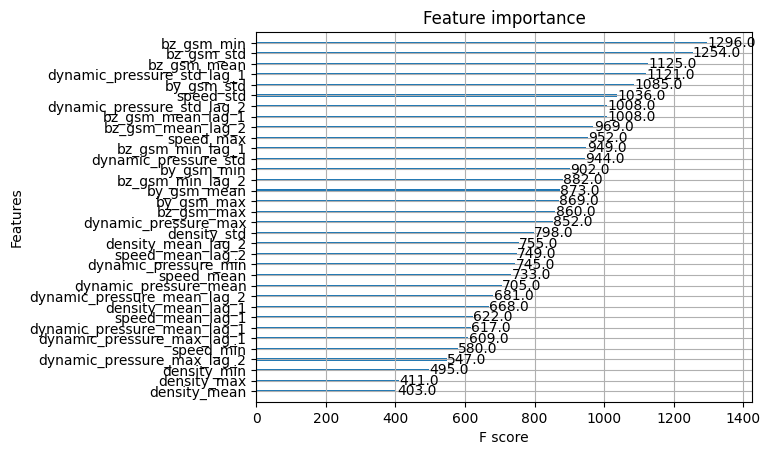

In [20]:
# Plotting feature importances using the plot_importance function from XGBoost
# Creating a directory for the model artifacts if it doesn't exist
images_dir = "./images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

plot_importance(model_kp_3h)
feature_importance_path = images_dir + "/feature_importance_3h.png"
plt.savefig(feature_importance_path)
plt.show()

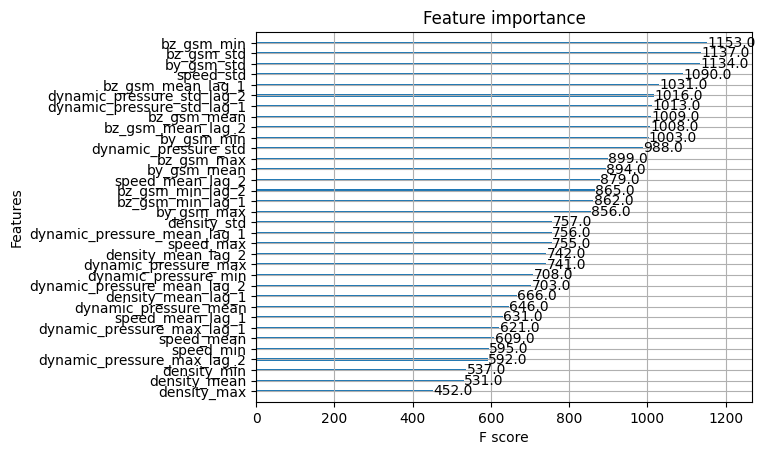

In [21]:
# Plotting feature importances using the plot_importance function from XGBoost
# Creating a directory for the model artifacts if it doesn't exist
images_dir = "./images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

plot_importance(model_kp_6h)
feature_importance_path = images_dir + "/feature_importance_6h.png"
plt.savefig(feature_importance_path)
plt.show()

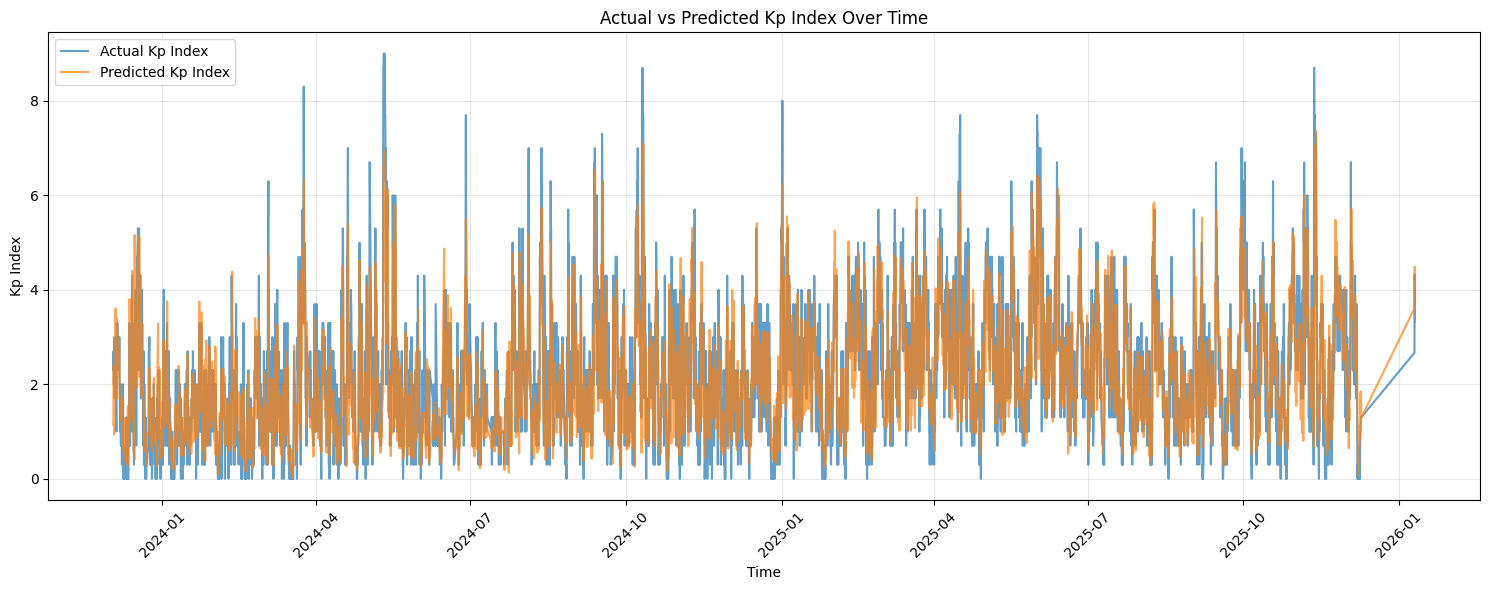

Plot saved to ./images/actual_vs_predicted_3h.png


In [22]:
# Create a comparison plot of actual vs predicted Kp index over time
plt.figure(figsize=(15, 6))

# Get the test dates from merged_df
test_dates = merged_df.loc[X_test.index, 'window_start']

plt.plot(test_dates, y_test_3h.values, label='Actual Kp Index', alpha=0.7, linewidth=1.5)
plt.plot(test_dates, y_pred_3h, label='Predicted Kp Index', alpha=0.7, linewidth=1.5)

plt.xlabel('Time')
plt.ylabel('Kp Index')
plt.title('Actual vs Predicted Kp Index Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
prediction_plot_path = images_dir + "/actual_vs_predicted_3h.png"
plt.savefig(prediction_plot_path)
plt.show()

print(f"Plot saved to {prediction_plot_path}")

# Step 5: Register Models to Hopsworks

Once satisfied with the performance, we save the model artifacts and register them in the Hopsworks Model Registry so they can be retrieved by the Batch Inference pipeline.

In [23]:
# Create a local directory for model artifacts
models_dir = "aurora_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Save the model artifact
model_3h_path = os.path.join(models_dir, "model_3h.pkl")
model_6h_path = os.path.join(models_dir, "model_6h.pkl")
joblib.dump(model_kp_3h, model_3h_path)
joblib.dump(model_kp_6h, model_6h_path)

# Get the Model Registry
mr = project.get_model_registry()

# Create the model entry
aurora_model_3h = mr.python.create_model(
    name=settings.MODEL_3H_NAME, # from config.py
    metrics=metrics,
    description="Random Forest Regressor for predicting Kp index based on solar wind features.",
    #input_example=X_train.sample(1),
    feature_view=aurora_fv
)
aurora_model_6h = mr.python.create_model(
    name=settings.MODEL_6H_NAME, # from config.py
    metrics=metrics,
    description="Random Forest Regressor for predicting Kp index based on solar wind features.",
    #input_example=X_train.sample(1),
    feature_view=aurora_fv
)

# Upload the model to the registry
aurora_model_3h.save(models_dir)
aurora_model_6h.save(models_dir)

print(f"Model '{settings.MODEL_3H_NAME}' version {aurora_model_3h.version} registered successfully.")
print(f"Model '{settings.MODEL_6H_NAME}' version {aurora_model_6h.version} registered successfully.")

2026-01-11 03:10:23,310 WARNING: ProvenanceWarning: Provenance cached data - feature view provided, but training dataset version is missing

2026-01-11 03:10:23,311 WARNING: ProvenanceWarning: Model schema cannot not be inferred without both the feature view and the training dataset version.



  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_models/model_3h.pkl: 0.000%|          | 0/2338408…

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_models/model_6h.pkl: 0.000%|          | 0/2323147…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1299605/models/aurora_kp_3h_model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_models/model_3h.pkl: 0.000%|          | 0/2338408…

Uploading /Users/nico/Documents/GitHub/ID2223_Project/aurora_models/model_6h.pkl: 0.000%|          | 0/2323147…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1299605/models/aurora_kp_6h_model/1
Model 'aurora_kp_3h_model' version 1 registered successfully.
Model 'aurora_kp_6h_model' version 1 registered successfully.
